# Data Prep

In [3]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [4]:
# Read in training set; pop sale price off of the training df to create Y_train
X_train = pd.read_csv('all/train.csv', index_col='Id')
Y_train = X_train.pop('SalePrice')

# Read in testing set
X_test = pd.read_csv('all/test.csv', index_col='Id')

# Create a combined DF to ensure that dummification works properly in test set
combined = pd.concat([X_train, X_test], axis=0, sort=False)
combined.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [5]:
# Drop unwanted features

drop_cols = ['BsmtCond', 'RoofMatl', 'MasVnrArea', 'BsmtHalfBath', 'GarageCars',
        'YearRemodAdd', 'Street', 'Alley', 'LandSlope', 'Utilities', 'Exterior2nd', 'ExterCond', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtUnfSF', 'BsmtFinType1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'KitchenAbvGr', 'FireplaceQu',
        'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PoolArea',
             'Fence', 'MiscFeature', 'MiscVal', 'SaleType']

combined = combined.drop(drop_cols, axis = 1)

In [6]:
# Lot Frontage

# Build a dictionary with the median lot frontage per neighborhood from X_train
X_train_median_frontage = X_train.groupby('Neighborhood').LotFrontage.median()
X_train_median_frontage = dict(X_train_median_frontage)

# Fill in NAs by getting the corresponding value from the dictionary based on x
combined['LotFrontage'] = combined.apply(lambda x:
                                         X_train_median_frontage.get(x.Neighborhood) if pd.isna(x.LotFrontage)
                                            else x.LotFrontage, axis = 1)

In [7]:
# Define a general dummy function that either
#       1) drops the first category if all categories are meaningfully large, or
#       2) keeps the first category, but drops the small categories if any categories are not meaningfull large

# Definition of meaningfully large is taken from counts from the training data, to avoid data leakage

def standard_dummies(col):
    col_value_counts = X_train[col].value_counts()
    
    # If all of the categories are big enough... just drop the first
    if X_train[col].value_counts().min() >= 30:
        return pd.get_dummies(combined[col], drop_first=True, prefix=col)
    
    # If some of the categoires are quite small... drop the small ones
    else:
        all_dumms = pd.get_dummies(combined[col].astype(str))
        
        drop_dumms = col_value_counts[col_value_counts < 30].index.astype(str)
        
        all_dumms = all_dumms.drop(drop_dumms, axis = 1)
        
        all_dumms.columns = all_dumms.columns.str.slice_replace(0, 0, col + '_')
        
        return all_dumms
    
standard_dummies('YrSold').head()

,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
Id,,,,
1,0,1,0,0
2,1,0,0,0
3,0,1,0,0
4,0,0,0,0
5,0,1,0,0


In [8]:
# Dummify the columns that are just getting straight dummy values

# Define list of columns
std_dumm_cols = ['MSSubClass', 'Neighborhood', 'MSZoning', 'LandContour', 'LotConfig', 'KitchenQual',
                 'Exterior1st', 'HouseStyle', 'CentralAir', 'Foundation', 'GarageType', 'RoofStyle',
                 'MasVnrType', 'MoSold', 'YrSold']

# Loop through each column
for col in std_dumm_cols:
    # Get the dummies
    dummies = standard_dummies(col)
    
    # Concat to the dataframe
    combined = pd.concat([combined, dummies], axis = 1)
    
    # Drop the original column
    combined = combined.drop(col, axis = 1)

combined.head()

,LotFrontage,LotArea,LotShape,Condition1,Condition2,BldgType,OverallQual,OverallCond,YearBuilt,ExterQual,...,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,Reg,Norm,Norm,1Fam,7,5,2003,Gd,...,0,0,0,0,0,0,0,1,0,0
2,80.0,9600,Reg,Feedr,Norm,1Fam,6,8,1976,TA,...,0,0,0,0,0,0,1,0,0,0
3,68.0,11250,IR1,Norm,Norm,1Fam,7,5,2001,Gd,...,0,0,1,0,0,0,0,1,0,0
4,60.0,9550,IR1,Norm,Norm,1Fam,7,5,1915,TA,...,0,0,0,0,0,0,0,0,0,0
5,84.0,14260,IR1,Norm,Norm,1Fam,8,5,2000,Gd,...,0,0,0,0,0,1,0,1,0,0


In [9]:
# Lot Area

from math import log

combined['LotArea'] = combined['LotArea'].apply(log)

In [10]:
# Lot shape -- turn into binary for regular vs. irregular

combined['LotShape_Reg'] = combined['LotShape'].apply(lambda x: 1 if x == 'Reg' else 0)
combined = combined.drop('LotShape', axis=1)

In [11]:
# Conditions

# Identify list of conditions to check for
conditions = set(list(combined['Condition1'].unique()) + list(combined['Condition1'].unique()))
conditions.remove('Norm')

# Concatenate the two conditions for each observation
combined_conds = combined['Condition1'] + ';' + combined['Condition2']

# Loop through each condition and create a binary if it exists in that observation
for cond in conditions:
    combined['conditions_{}'.format(cond)] = 1 if cond in combined_conds else 0

# Drop the original condition field
combined = combined.drop(['Condition1', 'Condition2'], axis=1)

In [12]:
# Building type

# Group the building types -- need to group X_train as well because standard dummies fn
# relies on the value counts in X_train
combined['BldgType'] = ['Twnhs' if x == 'TwnhsE' else '2fam' if x in ['Duplex', '2fmCon'] else x
                        for x in combined['BldgType']]
X_train['BldgType'] = ['Twnhs' if x == 'TwnhsE' else '2fam' if x in ['Duplex', '2fmCon'] else x
                        for x in X_train['BldgType']]

# Dummify and drop original column
combined = pd.concat([combined, standard_dummies('BldgType')], axis = 1)
combined = combined.drop('BldgType', axis=1)

In [13]:
# Overall Condition -- binary for if it is high quality (greater than or equal to 7)

combined['OverallCond'] = combined['OverallCond'].apply(lambda x: 1 if x >=7 else 0)

In [14]:
# Year Built -- enforce a minimum value of 1950

combined['YearBuilt'] = combined['YearBuilt'].apply(lambda x: 1950 if x < 1950 else x)

In [15]:
# Exterior Quality

# Combine Typical and Fair
combined['ExterQual'] = combined['ExterQual'].apply(lambda x: 'TA' if x == 'Fa' else x)
X_train['ExterQual'] = X_train['ExterQual'].apply(lambda x: 'TA' if x == 'Fa' else x)

# Dummify and drop original column
combined = pd.concat([combined, standard_dummies('ExterQual')], axis = 1)
combined = combined.drop('ExterQual', axis=1)

In [16]:
# Basement Quality... same thing

# Combine Typical and Fair
combined['BsmtQual'] = combined['BsmtQual'].apply(lambda x: 'TA' if x == 'Fa' else x)
X_train['BsmtQual'] = X_train['BsmtQual'].apply(lambda x: 'TA' if x == 'Fa' else x)

# Dummify and drop original column
combined = pd.concat([combined, standard_dummies('BsmtQual')], axis = 1)
combined = combined.drop('BsmtQual', axis=1)

In [17]:
# Basement Exposure -- is it avg or good?

combined['BsmtExposure_pos'] = combined['BsmtExposure'].apply(lambda x: 1 if x in ['Av', 'Gd'] else 0)

combined = combined.drop('BsmtExposure', axis = 1)

In [18]:
# Heating Type -- is it GasA?

combined['Heating_GasA'] = combined['Heating'].apply(lambda x: 1 if x == 'GasA' else 0)

combined = combined.drop('Heating', axis = 1)

In [19]:
# Heating Quality -- is it excellent?

combined['HeatingQC_ex'] = combined['HeatingQC'].apply(lambda x: 1 if x == 'Ex' else 0)

combined = combined.drop('HeatingQC', axis=1)

In [20]:
# Electrical -- breaker?

combined['Electrical_brkr'] = combined['Electrical'].apply(lambda x: 1 if x == 'SBrkr' else 0)

combined = combined.drop('Electrical', axis = 1)

In [21]:
# Low Qual Fin Sq Ft -- is there any?

combined['LowQualFinSF_y'] = combined['LowQualFinSF'].apply(lambda x: 1 if x > 0 else 0)

combined = combined.drop('LowQualFinSF', axis = 1)

In [22]:
# Half Bath -- is there one?

combined['HalfBath_y'] = combined['HalfBath'].apply(lambda x: 1 if x > 0 else 0)

combined = combined.drop('HalfBath', axis=1)

In [23]:
# Functional -- is there any damage?

combined['Functional_dmg'] = combined['Functional'].apply(lambda x: 0 if x == 'Typ' else 1)

combined = combined.drop('Functional', axis = 1)

In [24]:
# Fireplaces -- are they any?

combined['Fireplaces'] = combined['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [25]:
# Paved Drive -- is there a good paved driveway?

combined['PavedDrive'] = combined['PavedDrive'].apply(lambda x: 1 if x == 'Y' else 0)

In [26]:
# Porches -- what is the size and type of the largest porch?

# Gets a series of the porch sizes for each record;
# Sort the series by size; and returns idx(type)/value as a tuple
combined['Porch_tuple'] = combined.filter(regex = 'Porch|Deck').apply(lambda s:
                                                    list(s.sort_values(ascending=False)[[0]].iteritems())[0],
                                                                     axis = 1)

# Extract the size and type as separate columns from the tuple
combined['Porch_largest_type'] = combined['Porch_tuple'].apply(lambda t: t[0])
combined['porch_largest_size'] = combined.pop('Porch_tuple').apply(lambda t: t[1])

# Convert porch type to no porch if biggest size is zero
combined['Porch_largest_type'] = combined.apply(lambda s: 'No Porch' if s.porch_largest_size == 0
                                                else s.Porch_largest_type, axis=1)
                                                
# Get dummies for the largest porch type
combined = pd.concat([combined, pd.get_dummies(combined['Porch_largest_type'], drop_first=True)], axis=1)

# Drop the original columns and the tuple
combined = combined.drop(combined.filter(regex = 'Porch|Deck').columns, axis=1)

In [27]:
# Pool -- is there one?

combined['Pool_y'] = combined['PoolQC'].apply(lambda x: 0 if pd.isna(x) else 1)

combined = combined.drop('PoolQC', axis = 1)

In [28]:
# Sale condition -- is it partial or abnormal?

# Flag partial and abnormal sales
combined['SaleCondition_Partial'] = combined['SaleCondition'].apply(lambda x: 1 if x == 'Partial' else 0)
combined['SaleCondition_Abnorml'] = combined['SaleCondition'].apply(lambda x: 1 if x == 'Abnorml' else 0)

# Drop the original column
combined = combined.drop('SaleCondition', axis=1)

In [29]:
# Check dataframe

combined.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,TotalBsmtSF,GrLivArea,BsmtFullBath,FullBath,BedroomAbvGr,...,Heating_GasA,HeatingQC_ex,Electrical_brkr,LowQualFinSF_y,HalfBath_y,Functional_dmg,porch_largest_size,Pool_y,SaleCondition_Partial,SaleCondition_Abnorml
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,9.041922,7,0,2003,856.0,1710,1.0,2,3,...,1,1,1,0,1,0,61,0,0,0
2,80.0,9.169518,6,1,1976,1262.0,1262,0.0,2,3,...,1,1,1,0,0,0,298,0,0,0
3,68.0,9.328123,7,0,2001,920.0,1786,1.0,2,3,...,1,1,1,0,1,0,42,0,0,0
4,60.0,9.164296,7,0,1950,756.0,1717,1.0,1,3,...,1,0,1,0,0,0,272,0,0,1
5,84.0,9.565214,8,0,2000,1145.0,2198,1.0,2,4,...,1,1,1,0,1,0,192,0,0,0


In [30]:
# Confirm that we only have numerical values left

combined.dtypes.value_counts()

uint8      89
int64      29
float64     5
dtype: int64

In [31]:
# Check for any remaining NAs

combined.apply(lambda col: col.isna().sum()).sort_values(ascending=False).head()

BsmtFullBath            2
GarageArea              1
TotalBsmtSF             1
Neighborhood_SawyerW    0
MSZoning_RM             0
dtype: int64

In [32]:
# Fill remaining NAs with 0s

combined = combined.fillna(0)

In [33]:
# Split combined df back into X train and X test based on the index values

X_train = combined.loc[X_train.index, :]
X_test = combined.loc[X_test.index, :]

# Drop outliers from X_train and Y_train

X_train = X_train.drop([524, 1299], axis = 0)
Y_train = Y_train.drop([524, 1299], axis = 0)

print('X_train: {} obvs\nX_test: {} obvs'.format(len(X_train), len(X_test)))

X_train: 1458 obvs
X_test: 1459 obvs


# Modeling

In [298]:
import sklearn.model_selection as ms
k5 = ms.KFold(n_splits=5)
ms.cross_val_score(estimator=lm, X=X_train, y=Y_train, cv=k5)

array([0.89731801, 0.90650522, 0.88770929, 0.8893938 , 0.88052638])

In [299]:
from sklearn.linear_model import Lasso
lass = Lasso(max_iter = 100000)
ms.cross_val_score(estimator=lass, X=X_train, y=Y_train, cv=k5)

array([0.89765444, 0.90662115, 0.88783965, 0.88947851, 0.88078091])

In [300]:
alpha_vals = [{'alpha': 10.0**np.arange(-2, 10)}]
gridsearch = ms.GridSearchCV(estimator = lass, param_grid=alpha_vals, cv=k5, return_train_score=False)
gridres = gridsearch.fit(X_train, Y_train)

In [301]:
gridres.best_score_

0.894180111089756

In [302]:
gridres.best_params_.get('alpha')

100.0

In [303]:
_ = lass.set_params(alpha = gridres.best_params_.get('alpha'))
_ = lass.fit(X_train, Y_train)


coefffs = pd.Series(lass.coef_, index=X_train.columns)
coefffs.sort_values()

BsmtQual_Gd             -25188.725705
ExterQual_Gd            -22819.188592
BsmtQual_TA             -22761.141402
ExterQual_TA            -22457.446427
KitchenQual_TA          -20707.005532
KitchenQual_Gd          -20625.953433
KitchenQual_Fa          -20163.926257
Functional_dmg          -16677.174651
LowQualFinSF_y          -11615.527591
BldgType_2fam           -10565.657478
Neighborhood_Mitchel     -9802.785574
SaleCondition_Abnorml    -8757.462758
BedroomAbvGr             -7173.259067
Neighborhood_NWAmes      -6562.935906
MSSubClass_90            -6495.620010
Neighborhood_Gilbert     -5981.432833
Foundation_BrkTil        -4349.429410
Neighborhood_CollgCr     -4316.771994
Neighborhood_Timber      -3769.984925
Neighborhood_OldTown     -3678.896754
Neighborhood_Edwards     -3123.202542
Exterior1st_Plywood      -3017.416506
LotConfig_FR2            -2173.758914
Exterior1st_Wd Sdng      -1705.784212
YrSold_2009              -1648.635122
Neighborhood_NAmes       -1566.641612
MoSold_8    

In [304]:
predictions = pd.Series(lass.predict(X_test), index=X_test.index, name='SalePrice')
predictions.to_csv('predictions0.csv', header=True)

In [305]:
Y_train_log = np.log1p(Y_train)
X_train_log = X_train.copy()
X_test_log = X_test.copy()
for train in [X_train_log, X_test_log]:
    train.loc[:,train.dtypes != object] = train.loc[:,train.dtypes != object].apply(np.log1p)

In [313]:
alpha_vals = [{'alpha': 10.0**np.arange(-6, 10)}]
gridsearch = ms.GridSearchCV(estimator = lass, param_grid=alpha_vals, cv=k5, return_train_score=False)
gridreslog = gridsearch.fit(X_train_log, Y_train_log)

In [314]:
lass_log = gridreslog.best_estimator_
gridreslog.best_params_

{'alpha': 0.0001}

In [315]:
predict_lass_log = np.expm1(lass_log.predict(X_test_log))
predict_lass_log

array([110367.70205172, 152740.24660914, 164994.95134276, ...,
       159170.1254861 , 116493.70486341, 215405.34946024])

In [316]:
predictions = pd.Series(predict_lass_log, index=X_test.index, name='SalePrice')
predictions.to_csv('predictions1.csv', header=True)

In [318]:
coefffs = pd.Series(lass_log.coef_, index=X_train.columns)
coefffs.sort_values()

KitchenQual_Fa          -0.189211
Neighborhood_IDOTRR     -0.158748
BsmtQual_TA             -0.153299
KitchenQual_TA          -0.145407
Functional_dmg          -0.131499
SaleCondition_Abnorml   -0.117978
KitchenQual_Gd          -0.116727
BsmtQual_Gd             -0.109563
Neighborhood_OldTown    -0.105930
Neighborhood_Edwards    -0.098492
ExterQual_TA            -0.092571
Foundation_BrkTil       -0.087511
Neighborhood_NWAmes     -0.076642
ExterQual_Gd            -0.074914
Neighborhood_Mitchel    -0.071790
Neighborhood_Gilbert    -0.070210
LowQualFinSF_y          -0.066876
HouseStyle_2Story       -0.063810
Neighborhood_NAmes      -0.057301
Neighborhood_Sawyer     -0.056455
LotConfig_FR2           -0.054781
HouseStyle_1.5Fin       -0.053687
BedroomAbvGr            -0.052540
Neighborhood_CollgCr    -0.045018
Neighborhood_Timber     -0.038115
Neighborhood_SawyerW    -0.037980
Exterior1st_Wd Sdng     -0.032851
Foundation_CBlock       -0.029353
BldgType_2fam           -0.028182
YrSold_2010   

In [319]:
gridreslog.best_index_

2

# Some weird stuff../.

In [335]:
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor

In [641]:
lass_log_strong = Lasso(max_iter = 100000, alpha=0.001)

In [642]:
lass_log_crosspred = ms.cross_val_predict(lass_log_strong, X=X_train_log, y=Y_train_log, cv=k5)
lass_log_resid = Y_train_log - lass_log_crosspred

In [643]:
gb_params = [{'n_estimators': [10, 100, 250, 500],
              'max_depth': range(1, 10, 2),
              'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5]}]


a = ms.GridSearchCV(GradientBoostingRegressor(), gb_params)

#ms.cross_val_score(GradientBoostingRegressor(), X=X_train, y=lass_log_resid, cv=k5)

In [644]:
a.fit(X_train, lass_log_resid)

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 100, 250, 500], 'max_depth': range(1, 10, 2), 'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [645]:
a.best_params_
a.best_score_

{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}

0.05315048555607553

In [646]:
lass_log_strong.fit(X_train_log, Y_train_log)

gb = a.best_estimator_
gb.fit(X_train, lass_log_resid)

predicts = lass_log_strong.predict(X_test_log)

predicts += gb.predict(X_test)
predicts = np.expm1(predicts)


predictions = pd.Series(predicts, index=X_test.index, name='SalePrice')
predictions.to_csv('predictions4.csv', header=True)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=100000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=1, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

## Some even weirder stuff

In [554]:
from sklearn.base import RegressorMixin, BaseEstimator

class cross_val_regress_predict(BaseEstimator, RegressorMixin):
    
    def __init__(self, alpha=1):
        self.alpha = alpha
        
        from sklearn.linear_model import Lasso
        import sklearn.model_selection as ms
        import numpy as np
        self.lass = Lasso(max_iter = 100000)
        
    def fit(self, X, y):
        self.fitted = ms.cross_val_predict(self.lass, X=X, y=y, cv=5)
    
    def transform(self, X):
        return np.column_stack((self.fitted, X.drop()))
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return np.column_stack((self.fitted, X))

In [565]:
a = cross_val_regress_predict()
a.fit(X_train, Y_train)
a.transform(X_train)

array([[1.96036488e+05, 6.50000000e+01, 9.04192172e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.97672498e+05, 8.00000000e+01, 9.16951838e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.15595753e+05, 6.80000000e+01, 9.32812341e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.63870497e+05, 6.60000000e+01, 9.10963567e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.32715208e+05, 6.80000000e+01, 9.18163221e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.50167424e+05, 7.50000000e+01, 9.20402044e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [558]:
from sklearn.pipeline import make_union
mypipep = make_pipeline(cross_val_regress_predict(), GradientBoostingRegressor())

In [560]:
ms.cross_val_predict(mypipep, X=X_train_log, y=Y_train_log)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

# PRESENTATION (Normal Stuff)

In [34]:
import sklearn.model_selection as ms

In [35]:
from sklearn.metrics import make_scorer

def rmsle(ground_truth, predictions):
    '''
    this version works if Y has not been
    transformed (e.g., log transformed)
    '''
    from math import log1p, sqrt
    
    
    log1p_vec = np.vectorize(log1p)
    return sqrt(np.mean((log1p_vec(predictions) - log1p_vec(ground_truth))**2))


rmsle_s = make_scorer(rmsle, greater_is_better=False)

In [36]:
def rmsle_bc(ground_truth, predictions, l):
    '''
    this version reverses the boxcox transformation and gets
    RMSLE on the original Y values
    '''
    from math import log1p, sqrt
    from scipy.special import inv_boxcox
    
    
    ground_truth = inv_boxcox(ground_truth, l)
    predictions = inv_boxcox(predictions, l)
    
    
    log1p_vec = np.vectorize(log1p)
    return sqrt(np.mean((log1p_vec(predictions) - log1p_vec(ground_truth))**2))

In [37]:
def rmsle_log1p(ground_truth, predictions):
    '''
    this version leaves the log1p transformation
    '''
    from math import sqrt

    return sqrt(np.mean((predictions - ground_truth)**2))

rmsle_s_log1p = make_scorer(rmsle_log1p, greater_is_better=False)

In [46]:
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

In [57]:
plt.rcParams['figure.figsize'] = (4, 4) # defaults to half-page image
                                    #--> use this for a full-page image (9,4)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['savefig.bbox'] = 'tight'

## Simple linear regresion 1

In [59]:
# Train regression

from sklearn.linear_model import LinearRegression
lm = LinearRegression()
_ = lm.fit(X_train[['GrLivArea']], Y_train)

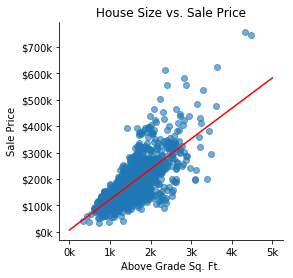

In [60]:
fig, ax = plt.subplots(1, 1)

# Scatter plot of X vs. Y
_ = ax.scatter(X_train.GrLivArea, Y_train, alpha=0.6)

# Add regression line to plot
_ = ax.plot([0, 5000], [lm.intercept_, lm.intercept_ + 5000*lm.coef_[0]], color='red')

# Formatting etc.
_ = ax.set_title('House Size vs. Sale Price')
_ = ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: str(int(x/1000)) + 'k'))
_ = ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: '$' + str(int(x/1000)) + 'k'))
_ = ax.set_xlabel('Above Grade Sq. Ft.')
_ = ax.set_ylabel('Sale Price')

# Save out
_ = plt.savefig('figures/1_scatter.png', format = 'png')

In [42]:
# Print out intercept, coefficient, and R^2 for slide

lm.intercept_, lm.coef_, lm.score(X_train[['GrLivArea']], Y_train)

(7168.969884852384, array([115.03998299]), 0.5401782028813179)

In [61]:
# Cross-val rmsle score for one-variable SLR

np.mean(ms.cross_val_score(lm, X_train[['GrLivArea']], Y_train, cv=5, scoring=rmsle_s))

-0.27290335270413796

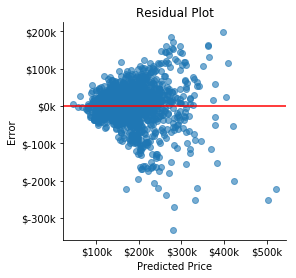

In [44]:
fig, ax = plt.subplots(1, 1)

# Get predictions and errors
predicted = lm.predict(X_train[['GrLivArea']])
error = predicted - Y_train

# Plot
_ = ax.scatter(predicted, error, alpha=0.6)

# Formatting, etc.
_ = ax.axhline(0, color='red')
_ = ax.set_title('Residual Plot')
_ = ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: '$' + str(int(x/1000)) + 'k'))
_ = ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: '$' + str(int(x/1000)) + 'k'))
_ = ax.set_xlabel('Predicted Price')
_ = ax.set_ylabel('Error')

# Save out
_ = plt.savefig('figures/2_slr_resid.png', format = 'png')

## Simple linear regression 2 -- variable transformation

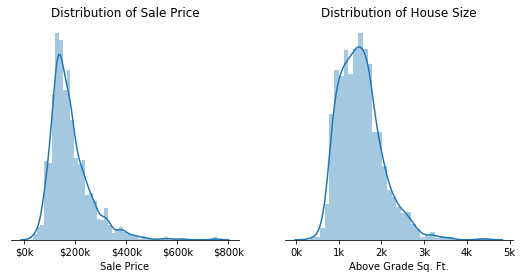

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(9,4))

# Histogram of sale price
_ = sns.distplot(Y_train, ax=ax[0])
_ = ax[0].axes.get_yaxis().set_visible(False)
_ = ax[0].spines['left'].set_visible(False)
_ = ax[0].set_xlabel('Sale Price')
_ = ax[0].set_title('Distribution of Sale Price')
_ = ax[0].get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: '$' + str(int(x/1000)) + 'k'))

# Histogram of house size
_ = sns.distplot(X_train['GrLivArea'], ax=ax[1])
_ = ax[1].set_xlabel('Above Grade Sq. Ft.')
_ = ax[1].axes.get_yaxis().set_visible(False)
_ = ax[1].spines['left'].set_visible(False)
_ = ax[1].set_title('Distribution of House Size')
_ = ax[1].get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: str(int(x/1000)) + 'k'))

# Save out
_ = plt.savefig('figures/3_slr_xydists.png', format = 'png')

In [49]:
from scipy.stats import boxcox

# Apply box-cox to X...

X_train_bc = X_train.apply(lambda x: boxcox(x - min(x) + 1)[0], axis=0, result_type = 'expand')
X_train_bc.columns = X_train.columns


# And to Y...

bc = boxcox(Y_train)
Y_train_bc = bc[0]

# Save the lambda value

la = bc[1]

/Users/johnmcglynn/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:900: RuntimeWarning: divide by zero encountered in log
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))
/Users/johnmcglynn/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1926: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/johnmcglynn/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1927: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


In [50]:
# Train model on box-coxed x and y

lm.fit(X_train_bc[['GrLivArea']], Y_train_bc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

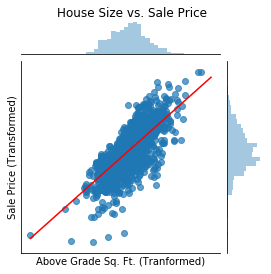

In [51]:
# Plot box-coxed x and y against each other

_ = sns.jointplot(X_train_bc['GrLivArea'], Y_train_bc, alpha=0.7, height=4)


# Add regression line

__ = _.ax_joint.plot([0, 70], [lm.intercept_, lm.intercept_ + lm.coef_[0]*70], color='red')


# Formatting

__ = _.ax_joint.set_xlabel('Above Grade Sq. Ft. (Tranformed)')
__ = _.ax_joint.set_ylabel('Sale Price (Transformed)')
__ = _.ax_joint.get_xaxis().set_ticks([])
__ = _.ax_joint.get_yaxis().set_ticks([])
__ = _.fig.suptitle('House Size vs. Sale Price', y = 1)


# Save figure

plt.savefig('figures/4_boxcoxed_lm.png', format = 'png')

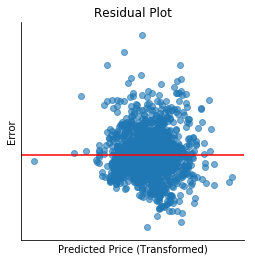

In [52]:
fig, ax = plt.subplots(1, 1)

# Get predictions and errors
predicted = lm.predict(X_train_bc[['GrLivArea']])
error = predicted - Y_train_bc

# Plot
_ = ax.scatter(predicted, error, alpha=0.6)

# Formatting, etc.
_ = ax.axhline(0, color='red')
_ = ax.set_title('Residual Plot')
_ = ax.get_xaxis().set_major_formatter(FuncFormatter(lambda x, p: '$' + str(int(x/1000)) + 'k'))
_ = ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: '$' + str(int(x/1000)) + 'k'))
_ = ax.set_xlabel('Predicted Price (Transformed)')
_ = ax.set_ylabel('Error')
_ = ax.set_xticks([])
_ = ax.set_yticks([])


# Save out
_ = plt.savefig('figures/5_bc_resid.png', format = 'png')

In [53]:
# Make the scorer based on the fitted lambda value

rmsle_s_bc = make_scorer(rmsle_bc, greater_is_better=False, l = la)

In [54]:
# Generate cross-val scores for box-cox

np.mean(ms.cross_val_score(lm, X = X_train_bc[['GrLivArea']],
                   y = Y_train_bc,
                   scoring = rmsle_s_bc,
                           cv = 5))

-0.2699533162626448

In [67]:
# Get R2

lm.fit(X = X_train_bc[['GrLivArea']],
                   y = Y_train_bc)
lm.score(X = X_train_bc[['GrLivArea']],
                   y = Y_train_bc)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

0.5434473082612119

## Multiple Variables

In [68]:
corrmat = train_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

NameError: name 'train_df' is not defined